In [1]:
import os
import json
import torch
from torch_geometric.data import Dataset, Data

class SingleFileEmbeddingPairDataset(Dataset):
    def __init__(self, json_path, feature_idx=None):
        super().__init__(os.path.dirname(json_path))
        # Load dataset (dict of model pairs)
        with open(json_path, 'r') as f:
            model_dict = json.load(f)
            self.all_pairs = [pair for _, pair in model_dict.items()]
        # Store which feature columns to use (e.g., first 4)
        self.feature_idx = feature_idx if feature_idx is not None else list(range(4))

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, idx):
        pair = self.all_pairs[idx]

        # --- Load node features for A ---
        A_ids = sorted(pair['A_embeddings'].keys(), key=lambda x: int(x))
        xA = torch.tensor(
            [pair['A_embeddings'][aid] for aid in A_ids],
            dtype=torch.float
        )[:, self.feature_idx]  # <-- Only use selected features

        # --- Load node features for B ---
        B_ids = sorted(pair['B_embeddings'].keys(), key=lambda x: int(x))
        xB = torch.tensor(
            [pair['B_embeddings'][bid] for bid in B_ids],
            dtype=torch.float
        )[:, self.feature_idx]  # <-- Only use selected features

        # --- Node ID → index maps ---
        A_id_to_idx = {int(aid): i for i, aid in enumerate(A_ids)}
        B_id_to_idx = {int(bid): i for i, bid in enumerate(B_ids)}

        # --- Load edges (make undirected) ---
        def convert_edges(edge_list, id_to_idx):
            edges = []
            for a, b in edge_list:
                if a in id_to_idx and b in id_to_idx:
                    edges.append([id_to_idx[a], id_to_idx[b]])
                    edges.append([id_to_idx[b], id_to_idx[a]])
            return torch.tensor(edges, dtype=torch.long).t().contiguous() \
                   if edges else torch.empty((2, 0), dtype=torch.long)

        A_edges_raw = pair.get("A_edges", [])
        B_edges_raw = pair.get("B_edges", [])
        edge_indexA = convert_edges(A_edges_raw, A_id_to_idx)
        edge_indexB = convert_edges(B_edges_raw, B_id_to_idx)

        # --- Build mapping tensor ---
        mappings = []
        for a, b in pair['mappings']:
            idx_a = -1 if a == "NULL" else A_id_to_idx.get(int(a), -1)
            idx_b = -1 if b == "NULL" else B_id_to_idx.get(int(b), -1)
            mappings.append([idx_a, idx_b])
        matches = torch.tensor(mappings, dtype=torch.long)

        # --- Return graph data ---
        dataA = Data(x=xA, edge_index=edge_indexA, xt_entity_ids=A_ids)
        dataB = Data(x=xB, edge_index=edge_indexB, xt_entity_ids=B_ids)
        return dataA, dataB, matches


In [2]:
import torch.nn as nn 
import torch.nn.functional as F 
from torch_geometric.nn import SAGEConv 
class GraphEncoder(nn.Module): 
    def __init__(self, input_dim, hidden_dim, out_dim): 
        super().__init__() 
        self.conv1 = SAGEConv(input_dim, hidden_dim) 
        self.conv2 = SAGEConv(hidden_dim, hidden_dim) 
        self.conv3 = SAGEConv(hidden_dim, out_dim) 
    def forward(self, x, edge_index): 
        x = F.relu(self.conv1(x, edge_index)) 
        x = F.relu(self.conv2(x, edge_index)) 
        x = self.conv3(x, edge_index) 
        return x 
class SiameseGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim): 
        super().__init__() 
        self.encoder = GraphEncoder(in_dim, hidden_dim, out_dim) 
    def forward(self, data1, data2): 
        h1 = self.encoder(data1.x, data1.edge_index) # [N1, out_dim] 
        
        h2 = self.encoder(data2.x, data2.edge_index) # [N2, out_dim]
        h1 = F.normalize(h1, p=2, dim=1)
        h2 = F.normalize(h2, p=2, dim=1)

        return h1, h2

In [3]:
import torch
import torch.nn.functional as F

# --- Core Contrastive Margin Loss ---
def contrastive_margin_loss(emb1, emb2, matches_pos, matches_neg, margin=3.0):
    """
    emb1: [N1, D]
    emb2: [N2, D]
    matches_pos: [K1, 2]  -> positive pairs (valid correspondences)
    matches_neg: [K2, 2]  -> negative pairs (non-correspondences)
    margin: margin distance for negatives
    """
    if matches_pos.numel() == 0:
        # No positives in this batch → zero loss but keep graph
        return (emb1.sum() * 0.0) + (emb2.sum() * 0.0)

    # ---- Positive loss (want small distances) ----
    pos1 = emb1[matches_pos[:, 0]]
    pos2 = emb2[matches_pos[:, 1]]
    pos_dist = (pos1 - pos2).pow(2).sum(dim=1)
    pos_loss = pos_dist.mean()

    # ---- Negative loss (want large distances > margin) ----
    if matches_neg.numel() == 0:
        neg_loss = torch.tensor(0.0, device=emb1.device)
    else:
        neg1 = emb1[matches_neg[:, 0]]
        neg2 = emb2[matches_neg[:, 1]]
        neg_dist = (neg1 - neg2).pow(2).sum(dim=1)
        neg_loss = F.relu(margin - neg_dist).mean()

    return pos_loss + neg_loss


# --- Random negative sampling ---
def get_random_negatives(matches_pos, emb1_size, emb2_size, num_neg=None):
    num_pos = matches_pos.size(0)
    num_neg = num_neg or num_pos

    rand_A = torch.randint(0, emb1_size, (num_neg,))
    rand_B = torch.randint(0, emb2_size, (num_neg,))
    mask = torch.ones(num_neg, dtype=torch.bool)
    pos_set = set(map(tuple, matches_pos.tolist()))
    for i in range(num_neg):
        if (rand_A[i].item(), rand_B[i].item()) in pos_set:
            mask[i] = False
    return torch.stack([rand_A[mask], rand_B[mask]], dim=1)


# --- Hard negative sampling ---
def get_hard_negatives(emb1, emb2, matches_pos, top_k=3):
    """
    Select hardest negatives (closest embeddings not in positive set)
    """
    with torch.no_grad():
        dist = torch.cdist(emb1, emb2, p=2)  # [N1, N2]
        pos_mask = torch.zeros_like(dist, dtype=torch.bool)
        pos_mask[matches_pos[:, 0], matches_pos[:, 1]] = True
        dist[pos_mask] = 1e6  # mask out positives

        # Select top-k smallest distances as negatives
        neg_indices = dist.topk(k=top_k, largest=False).indices  # [N1, top_k]
        matches_neg = []
        for i in range(neg_indices.size(0)):
            for j in neg_indices[i]:
                matches_neg.append([i, j.item()])
        matches_neg = torch.tensor(matches_neg, dtype=torch.long, device=emb1.device)
    return matches_neg


# --- Mixed negative sampling (recommended) ---
def get_mixed_negatives(emb1, emb2, matches_pos, ratio=0.5, top_k=3):
    """
    Combines random + hard negatives
    """
    hard_negs = get_hard_negatives(emb1, emb2, matches_pos, top_k)
    rand_negs = get_random_negatives(matches_pos, emb1.size(0), emb2.size(0))

    hard_negs = hard_negs.to(emb1.device)
    rand_negs = rand_negs.to(emb1.device)
    num_hard = int(ratio * min(len(hard_negs), len(rand_negs)))
    if num_hard == 0:
        return rand_negs
    mixed = torch.cat([hard_negs[:num_hard], rand_negs[:num_hard]], dim=0)
    return mixed



In [4]:
def batch_accuracy(emb1, emb2, matches):
    # emb1: [N1, D], emb2: [N2, D], matches: [K,2]
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None  # avoid NaN

    dists = torch.cdist(emb1, emb2)  # [N1, N2]
    # For each ground-truth emb1 index, which emb2 is closest
    min_indices = torch.argmin(dists[indices1], dim=1)
    correct = (min_indices == indices2).float()
    return correct.mean().item()

In [5]:
def batch_topk_accuracy(emb1, emb2, matches, k=5):
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None

    dists = torch.cdist(emb1, emb2)

    actual_k = min(k, emb2.shape[0])
    if actual_k == 0:
        return None  # no candidates

    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices
    correct = torch.any(topk == indices2.unsqueeze(1), dim=1).float()
    return correct.mean().item()

In [6]:
def batch_f1_score(emb1, emb2, matches, threshold=0.7):
    """Compute F1 score for one pair based on cosine similarity."""
    sim = F.cosine_similarity(
        emb1.unsqueeze(1), emb2.unsqueeze(0), dim=-1
    )  # shape: [N1, N2]
    preds = (sim > threshold).float()

    # Ground truth
    gt = torch.zeros_like(preds)
    for a, b in matches:
        if a != -1 and b != -1:
            gt[a, b] = 1.0

    TP = (preds * gt).sum().item()
    FP = (preds * (1 - gt)).sum().item()
    FN = ((1 - preds) * gt).sum().item()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return f1


In [7]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

#  Load dataset
dataset = SingleFileEmbeddingPairDataset("C:\\Users\\Z0054udc\\Downloads\\Siamese GNN\\XT_merged_doubled_new.json", feature_idx=list(range(4))) # Use first 4 features only
print(f"Found {len(dataset)} dataset entries.")
if len(dataset) == 0:
    raise ValueError("ERROR: No JSON files found!")

#  Device setup
device = torch.device('cpu')
print("Using device:", device)

#  Model and optimizer
model = SiameseGNN(in_dim=4, hidden_dim=16, out_dim=8).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)


#  Training hyperparameters
epochs = 250
grad_accum_steps = 8        # Simulates batch size = 8
loss_history, top1_history, top5_history, f1_history = [], [], [], []

#  Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_f1 = 0.0
    num_acc = 0
    optimizer.zero_grad()

    for i in tqdm(range(len(dataset)), desc=f"Epoch {epoch+1}"):
        data1, data2, matches = dataset[i]
        data1, data2, matches = data1.to(device), data2.to(device), matches.to(device)

        # Forward pass for this pair
        emb1, emb2 = model(data1, data2)
        matches_pos = matches[(matches[:, 0] != -1) & (matches[:, 1] != -1)]
        matches_neg = get_mixed_negatives(emb1, emb2, matches_pos, ratio=0.5, top_k=3)
        loss = contrastive_margin_loss(emb1, emb2, matches_pos, matches_neg)
        loss.backward()

        total_loss += loss.item()

        # --- Accuracy tracking
        acc1 = batch_accuracy(emb1, emb2, matches)
        acc5 = batch_topk_accuracy(emb1, emb2, matches, k=5)
        f1 = batch_f1_score(emb1, emb2, matches)
        if acc1 is not None and acc5 is not None:
            total_top1 += acc1
            total_top5 += acc5
            total_f1 += f1
            num_acc += 1

        # --- Gradient accumulation ---
        if (i + 1) % grad_accum_steps == 0 or (i + 1) == len(dataset):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            optimizer.zero_grad()

    # ---- Epoch summary ----
    avg_loss = total_loss / len(dataset)
    avg_top1 = (total_top1 / num_acc) * 100 if num_acc > 0 else 0.0
    avg_top5 = (total_top5 / num_acc) * 100 if num_acc > 0 else 0.0
    avg_f1 = (total_f1 / num_acc) * 100 if num_acc > 0 else 0.0
    
    f1_history.append(avg_f1)
    loss_history.append(avg_loss)
    top1_history.append(avg_top1)
    top5_history.append(avg_top5)

    print(f"Epoch {epoch+1:03d}: Loss = {avg_loss:.4f}, Top-1 = {avg_top1:.2f}%, Top-5 = {avg_top5:.2f}%, F1 = {avg_f1:.2f}%")



Found 134 dataset entries.
Using device: cpu


Epoch 1: 100%|██████████| 134/134 [00:01<00:00, 87.47it/s] 


Epoch 001: Loss = 2.7025, Top-1 = 25.33%, Top-5 = 59.21%, F1 = 7.08%


Epoch 2: 100%|██████████| 134/134 [00:01<00:00, 95.70it/s] 


Epoch 002: Loss = 2.5534, Top-1 = 26.17%, Top-5 = 58.92%, F1 = 8.98%


Epoch 3: 100%|██████████| 134/134 [00:01<00:00, 114.15it/s]


Epoch 003: Loss = 2.3930, Top-1 = 26.81%, Top-5 = 59.21%, F1 = 10.42%


Epoch 4: 100%|██████████| 134/134 [00:01<00:00, 125.31it/s]


Epoch 004: Loss = 2.3796, Top-1 = 25.44%, Top-5 = 59.45%, F1 = 11.08%


Epoch 5: 100%|██████████| 134/134 [00:01<00:00, 124.55it/s]


Epoch 005: Loss = 2.3595, Top-1 = 25.06%, Top-5 = 58.41%, F1 = 11.21%


Epoch 6: 100%|██████████| 134/134 [00:01<00:00, 122.64it/s]


Epoch 006: Loss = 2.3183, Top-1 = 25.52%, Top-5 = 59.20%, F1 = 11.14%


Epoch 7: 100%|██████████| 134/134 [00:01<00:00, 121.66it/s]


Epoch 007: Loss = 2.3342, Top-1 = 26.60%, Top-5 = 59.24%, F1 = 11.00%


Epoch 8: 100%|██████████| 134/134 [00:01<00:00, 124.43it/s]


Epoch 008: Loss = 2.3243, Top-1 = 26.12%, Top-5 = 58.91%, F1 = 11.09%


Epoch 9: 100%|██████████| 134/134 [00:01<00:00, 106.13it/s]


Epoch 009: Loss = 2.3055, Top-1 = 26.07%, Top-5 = 58.74%, F1 = 10.93%


Epoch 10: 100%|██████████| 134/134 [00:01<00:00, 117.79it/s]


Epoch 010: Loss = 2.3009, Top-1 = 26.38%, Top-5 = 59.18%, F1 = 11.21%


Epoch 11: 100%|██████████| 134/134 [00:01<00:00, 120.84it/s]


Epoch 011: Loss = 2.2893, Top-1 = 26.13%, Top-5 = 58.78%, F1 = 11.59%


Epoch 12: 100%|██████████| 134/134 [00:01<00:00, 116.56it/s]


Epoch 012: Loss = 2.3165, Top-1 = 26.23%, Top-5 = 58.55%, F1 = 11.18%


Epoch 13: 100%|██████████| 134/134 [00:01<00:00, 114.85it/s]


Epoch 013: Loss = 2.2763, Top-1 = 26.26%, Top-5 = 59.25%, F1 = 10.79%


Epoch 14: 100%|██████████| 134/134 [00:01<00:00, 114.97it/s]


Epoch 014: Loss = 2.3036, Top-1 = 26.34%, Top-5 = 58.85%, F1 = 11.71%


Epoch 15: 100%|██████████| 134/134 [00:01<00:00, 106.44it/s]


Epoch 015: Loss = 2.2806, Top-1 = 26.48%, Top-5 = 58.57%, F1 = 11.40%


Epoch 16: 100%|██████████| 134/134 [00:01<00:00, 120.55it/s]


Epoch 016: Loss = 2.2631, Top-1 = 26.78%, Top-5 = 58.50%, F1 = 11.54%


Epoch 17: 100%|██████████| 134/134 [00:01<00:00, 123.12it/s]


Epoch 017: Loss = 2.2725, Top-1 = 26.25%, Top-5 = 58.86%, F1 = 11.70%


Epoch 18: 100%|██████████| 134/134 [00:01<00:00, 124.03it/s]


Epoch 018: Loss = 2.2807, Top-1 = 26.01%, Top-5 = 59.05%, F1 = 11.81%


Epoch 19: 100%|██████████| 134/134 [00:01<00:00, 120.98it/s]


Epoch 019: Loss = 2.2609, Top-1 = 26.21%, Top-5 = 59.42%, F1 = 11.82%


Epoch 20: 100%|██████████| 134/134 [00:01<00:00, 121.56it/s]


Epoch 020: Loss = 2.2548, Top-1 = 26.66%, Top-5 = 59.68%, F1 = 11.84%


Epoch 21: 100%|██████████| 134/134 [00:01<00:00, 115.88it/s]


Epoch 021: Loss = 2.2530, Top-1 = 26.42%, Top-5 = 58.71%, F1 = 11.82%


Epoch 22: 100%|██████████| 134/134 [00:01<00:00, 121.01it/s]


Epoch 022: Loss = 2.2619, Top-1 = 25.85%, Top-5 = 59.05%, F1 = 11.78%


Epoch 23: 100%|██████████| 134/134 [00:01<00:00, 101.87it/s]


Epoch 023: Loss = 2.2686, Top-1 = 25.91%, Top-5 = 59.13%, F1 = 11.82%


Epoch 24: 100%|██████████| 134/134 [00:01<00:00, 119.12it/s]


Epoch 024: Loss = 2.2691, Top-1 = 25.62%, Top-5 = 57.80%, F1 = 11.82%


Epoch 25: 100%|██████████| 134/134 [00:01<00:00, 114.39it/s]


Epoch 025: Loss = 2.2026, Top-1 = 25.15%, Top-5 = 58.70%, F1 = 11.79%


Epoch 26: 100%|██████████| 134/134 [00:01<00:00, 118.33it/s]


Epoch 026: Loss = 2.2535, Top-1 = 25.65%, Top-5 = 58.68%, F1 = 11.79%


Epoch 27: 100%|██████████| 134/134 [00:01<00:00, 119.66it/s]


Epoch 027: Loss = 2.2911, Top-1 = 26.27%, Top-5 = 59.12%, F1 = 11.80%


Epoch 28: 100%|██████████| 134/134 [00:01<00:00, 121.99it/s]


Epoch 028: Loss = 2.2748, Top-1 = 26.54%, Top-5 = 58.56%, F1 = 11.88%


Epoch 29: 100%|██████████| 134/134 [00:01<00:00, 120.46it/s]


Epoch 029: Loss = 2.2918, Top-1 = 25.98%, Top-5 = 57.84%, F1 = 11.84%


Epoch 30: 100%|██████████| 134/134 [00:01<00:00, 115.97it/s]


Epoch 030: Loss = 2.2522, Top-1 = 25.88%, Top-5 = 58.72%, F1 = 11.89%


Epoch 31: 100%|██████████| 134/134 [00:01<00:00, 101.02it/s]


Epoch 031: Loss = 2.2787, Top-1 = 25.84%, Top-5 = 58.45%, F1 = 11.82%


Epoch 32: 100%|██████████| 134/134 [00:01<00:00, 120.57it/s]


Epoch 032: Loss = 2.2269, Top-1 = 26.02%, Top-5 = 58.22%, F1 = 11.78%


Epoch 33: 100%|██████████| 134/134 [00:01<00:00, 120.46it/s]


Epoch 033: Loss = 2.2681, Top-1 = 26.30%, Top-5 = 58.16%, F1 = 11.81%


Epoch 34: 100%|██████████| 134/134 [00:01<00:00, 119.87it/s]


Epoch 034: Loss = 2.2718, Top-1 = 26.55%, Top-5 = 58.63%, F1 = 11.81%


Epoch 35: 100%|██████████| 134/134 [00:01<00:00, 121.77it/s]


Epoch 035: Loss = 2.2562, Top-1 = 26.81%, Top-5 = 58.03%, F1 = 11.82%


Epoch 36: 100%|██████████| 134/134 [00:01<00:00, 117.80it/s]


Epoch 036: Loss = 2.2914, Top-1 = 27.01%, Top-5 = 58.71%, F1 = 11.76%


Epoch 37: 100%|██████████| 134/134 [00:01<00:00, 112.24it/s]


Epoch 037: Loss = 2.2463, Top-1 = 27.04%, Top-5 = 58.01%, F1 = 11.80%


Epoch 38: 100%|██████████| 134/134 [00:01<00:00, 113.61it/s]


Epoch 038: Loss = 2.2364, Top-1 = 26.01%, Top-5 = 58.19%, F1 = 11.77%


Epoch 39: 100%|██████████| 134/134 [00:01<00:00, 103.96it/s]


Epoch 039: Loss = 2.2152, Top-1 = 26.49%, Top-5 = 57.81%, F1 = 11.82%


Epoch 40: 100%|██████████| 134/134 [00:01<00:00, 116.88it/s]


Epoch 040: Loss = 2.2121, Top-1 = 26.53%, Top-5 = 58.56%, F1 = 11.85%


Epoch 41: 100%|██████████| 134/134 [00:01<00:00, 116.43it/s]


Epoch 041: Loss = 2.2369, Top-1 = 27.14%, Top-5 = 58.91%, F1 = 11.77%


Epoch 42: 100%|██████████| 134/134 [00:01<00:00, 122.00it/s]


Epoch 042: Loss = 2.2682, Top-1 = 26.95%, Top-5 = 58.59%, F1 = 11.80%


Epoch 43: 100%|██████████| 134/134 [00:01<00:00, 115.47it/s]


Epoch 043: Loss = 2.2556, Top-1 = 27.26%, Top-5 = 58.19%, F1 = 11.69%


Epoch 44: 100%|██████████| 134/134 [00:01<00:00, 121.61it/s]


Epoch 044: Loss = 2.1837, Top-1 = 27.07%, Top-5 = 58.05%, F1 = 11.70%


Epoch 45: 100%|██████████| 134/134 [00:01<00:00, 122.89it/s]


Epoch 045: Loss = 2.2111, Top-1 = 26.93%, Top-5 = 57.98%, F1 = 11.81%


Epoch 46: 100%|██████████| 134/134 [00:01<00:00, 120.77it/s]


Epoch 046: Loss = 2.2260, Top-1 = 26.66%, Top-5 = 57.96%, F1 = 11.86%


Epoch 47: 100%|██████████| 134/134 [00:01<00:00, 104.73it/s]


Epoch 047: Loss = 2.2920, Top-1 = 26.03%, Top-5 = 57.53%, F1 = 12.01%


Epoch 48: 100%|██████████| 134/134 [00:01<00:00, 119.28it/s]


Epoch 048: Loss = 2.1875, Top-1 = 26.54%, Top-5 = 58.46%, F1 = 11.82%


Epoch 49: 100%|██████████| 134/134 [00:01<00:00, 116.85it/s]


Epoch 049: Loss = 2.2713, Top-1 = 26.00%, Top-5 = 57.65%, F1 = 11.84%


Epoch 50: 100%|██████████| 134/134 [00:01<00:00, 123.96it/s]


Epoch 050: Loss = 2.2017, Top-1 = 26.37%, Top-5 = 57.70%, F1 = 11.85%


Epoch 51: 100%|██████████| 134/134 [00:01<00:00, 122.11it/s]


Epoch 051: Loss = 2.2469, Top-1 = 26.44%, Top-5 = 58.10%, F1 = 11.96%


Epoch 52: 100%|██████████| 134/134 [00:01<00:00, 123.46it/s]


Epoch 052: Loss = 2.2292, Top-1 = 26.89%, Top-5 = 57.84%, F1 = 12.02%


Epoch 53: 100%|██████████| 134/134 [00:01<00:00, 121.06it/s]


Epoch 053: Loss = 2.2279, Top-1 = 26.66%, Top-5 = 58.39%, F1 = 11.92%


Epoch 54: 100%|██████████| 134/134 [00:01<00:00, 121.78it/s]


Epoch 054: Loss = 2.2224, Top-1 = 26.99%, Top-5 = 58.80%, F1 = 11.94%


Epoch 55: 100%|██████████| 134/134 [00:01<00:00, 103.04it/s]


Epoch 055: Loss = 2.2346, Top-1 = 26.87%, Top-5 = 58.64%, F1 = 11.94%


Epoch 56: 100%|██████████| 134/134 [00:01<00:00, 121.94it/s]


Epoch 056: Loss = 2.2213, Top-1 = 26.62%, Top-5 = 58.39%, F1 = 12.01%


Epoch 57: 100%|██████████| 134/134 [00:01<00:00, 123.35it/s]


Epoch 057: Loss = 2.2246, Top-1 = 26.84%, Top-5 = 59.47%, F1 = 11.79%


Epoch 58: 100%|██████████| 134/134 [00:01<00:00, 119.62it/s]


Epoch 058: Loss = 2.2390, Top-1 = 26.71%, Top-5 = 58.43%, F1 = 11.90%


Epoch 59: 100%|██████████| 134/134 [00:01<00:00, 119.91it/s]


Epoch 059: Loss = 2.2347, Top-1 = 26.68%, Top-5 = 58.84%, F1 = 12.15%


Epoch 60: 100%|██████████| 134/134 [00:01<00:00, 120.73it/s]


Epoch 060: Loss = 2.1999, Top-1 = 27.04%, Top-5 = 58.96%, F1 = 12.13%


Epoch 61: 100%|██████████| 134/134 [00:01<00:00, 115.28it/s]


Epoch 061: Loss = 2.2015, Top-1 = 26.76%, Top-5 = 59.16%, F1 = 12.03%


Epoch 62: 100%|██████████| 134/134 [00:01<00:00, 120.51it/s]


Epoch 062: Loss = 2.2470, Top-1 = 27.07%, Top-5 = 58.56%, F1 = 12.04%


Epoch 63: 100%|██████████| 134/134 [00:01<00:00, 104.20it/s]


Epoch 063: Loss = 2.1923, Top-1 = 26.91%, Top-5 = 58.84%, F1 = 12.18%


Epoch 64: 100%|██████████| 134/134 [00:01<00:00, 117.50it/s]


Epoch 064: Loss = 2.1830, Top-1 = 26.62%, Top-5 = 58.38%, F1 = 12.13%


Epoch 65: 100%|██████████| 134/134 [00:01<00:00, 108.38it/s]


Epoch 065: Loss = 2.1901, Top-1 = 26.83%, Top-5 = 58.67%, F1 = 12.13%


Epoch 66: 100%|██████████| 134/134 [00:01<00:00, 123.01it/s]


Epoch 066: Loss = 2.1856, Top-1 = 26.76%, Top-5 = 58.46%, F1 = 12.33%


Epoch 67: 100%|██████████| 134/134 [00:01<00:00, 117.18it/s]


Epoch 067: Loss = 2.2433, Top-1 = 27.02%, Top-5 = 58.31%, F1 = 12.44%


Epoch 68: 100%|██████████| 134/134 [00:01<00:00, 119.27it/s]


Epoch 068: Loss = 2.2158, Top-1 = 27.07%, Top-5 = 58.53%, F1 = 12.34%


Epoch 69: 100%|██████████| 134/134 [00:01<00:00, 113.42it/s]


Epoch 069: Loss = 2.1938, Top-1 = 26.82%, Top-5 = 58.69%, F1 = 12.32%


Epoch 70: 100%|██████████| 134/134 [00:01<00:00, 113.41it/s]


Epoch 070: Loss = 2.2127, Top-1 = 26.63%, Top-5 = 57.89%, F1 = 12.35%


Epoch 71: 100%|██████████| 134/134 [00:01<00:00, 106.56it/s]


Epoch 071: Loss = 2.1677, Top-1 = 27.15%, Top-5 = 58.48%, F1 = 12.28%


Epoch 72: 100%|██████████| 134/134 [00:01<00:00, 121.83it/s]


Epoch 072: Loss = 2.2061, Top-1 = 26.56%, Top-5 = 58.15%, F1 = 12.14%


Epoch 73: 100%|██████████| 134/134 [00:01<00:00, 114.34it/s]


Epoch 073: Loss = 2.2473, Top-1 = 26.44%, Top-5 = 58.25%, F1 = 12.17%


Epoch 74: 100%|██████████| 134/134 [00:01<00:00, 123.75it/s]


Epoch 074: Loss = 2.2000, Top-1 = 26.27%, Top-5 = 58.66%, F1 = 12.44%


Epoch 75: 100%|██████████| 134/134 [00:01<00:00, 124.38it/s]


Epoch 075: Loss = 2.1580, Top-1 = 26.80%, Top-5 = 58.88%, F1 = 12.36%


Epoch 76: 100%|██████████| 134/134 [00:01<00:00, 120.77it/s]


Epoch 076: Loss = 2.1737, Top-1 = 25.80%, Top-5 = 57.80%, F1 = 12.43%


Epoch 77: 100%|██████████| 134/134 [00:01<00:00, 125.19it/s]


Epoch 077: Loss = 2.2431, Top-1 = 26.33%, Top-5 = 58.57%, F1 = 12.21%


Epoch 78: 100%|██████████| 134/134 [00:01<00:00, 122.17it/s]


Epoch 078: Loss = 2.2543, Top-1 = 26.69%, Top-5 = 57.75%, F1 = 12.33%


Epoch 79: 100%|██████████| 134/134 [00:01<00:00, 100.98it/s]


Epoch 079: Loss = 2.2134, Top-1 = 26.24%, Top-5 = 58.34%, F1 = 12.16%


Epoch 80: 100%|██████████| 134/134 [00:01<00:00, 123.20it/s]


Epoch 080: Loss = 2.1908, Top-1 = 26.05%, Top-5 = 57.46%, F1 = 12.49%


Epoch 81: 100%|██████████| 134/134 [00:01<00:00, 123.92it/s]


Epoch 081: Loss = 2.1801, Top-1 = 26.22%, Top-5 = 58.35%, F1 = 12.44%


Epoch 82: 100%|██████████| 134/134 [00:01<00:00, 123.80it/s]


Epoch 082: Loss = 2.1814, Top-1 = 26.64%, Top-5 = 58.17%, F1 = 12.48%


Epoch 83: 100%|██████████| 134/134 [00:01<00:00, 125.19it/s]


Epoch 083: Loss = 2.2432, Top-1 = 26.24%, Top-5 = 58.03%, F1 = 12.49%


Epoch 84: 100%|██████████| 134/134 [00:01<00:00, 125.43it/s]


Epoch 084: Loss = 2.2027, Top-1 = 26.32%, Top-5 = 58.26%, F1 = 12.36%


Epoch 85: 100%|██████████| 134/134 [00:01<00:00, 124.26it/s]


Epoch 085: Loss = 2.1952, Top-1 = 26.34%, Top-5 = 57.92%, F1 = 12.41%


Epoch 86: 100%|██████████| 134/134 [00:01<00:00, 117.86it/s]


Epoch 086: Loss = 2.2014, Top-1 = 25.98%, Top-5 = 57.81%, F1 = 12.33%


Epoch 87: 100%|██████████| 134/134 [00:01<00:00, 108.59it/s]


Epoch 087: Loss = 2.2026, Top-1 = 26.13%, Top-5 = 57.57%, F1 = 12.32%


Epoch 88: 100%|██████████| 134/134 [00:01<00:00, 124.26it/s]


Epoch 088: Loss = 2.1708, Top-1 = 25.77%, Top-5 = 57.85%, F1 = 12.49%


Epoch 89: 100%|██████████| 134/134 [00:01<00:00, 121.17it/s]


Epoch 089: Loss = 2.1963, Top-1 = 26.52%, Top-5 = 57.69%, F1 = 12.36%


Epoch 90: 100%|██████████| 134/134 [00:01<00:00, 122.39it/s]


Epoch 090: Loss = 2.1949, Top-1 = 26.17%, Top-5 = 57.65%, F1 = 12.31%


Epoch 91: 100%|██████████| 134/134 [00:01<00:00, 118.38it/s]


Epoch 091: Loss = 2.1893, Top-1 = 25.53%, Top-5 = 57.12%, F1 = 12.82%


Epoch 92: 100%|██████████| 134/134 [00:01<00:00, 125.19it/s]


Epoch 092: Loss = 2.2106, Top-1 = 26.10%, Top-5 = 57.33%, F1 = 12.76%


Epoch 93: 100%|██████████| 134/134 [00:01<00:00, 118.44it/s]


Epoch 093: Loss = 2.2002, Top-1 = 26.12%, Top-5 = 57.44%, F1 = 12.80%


Epoch 94: 100%|██████████| 134/134 [00:01<00:00, 124.67it/s]


Epoch 094: Loss = 2.1804, Top-1 = 26.41%, Top-5 = 57.91%, F1 = 12.61%


Epoch 95: 100%|██████████| 134/134 [00:01<00:00, 108.38it/s]


Epoch 095: Loss = 2.1691, Top-1 = 25.76%, Top-5 = 57.51%, F1 = 12.72%


Epoch 96: 100%|██████████| 134/134 [00:01<00:00, 121.43it/s]


Epoch 096: Loss = 2.2303, Top-1 = 25.86%, Top-5 = 57.88%, F1 = 12.83%


Epoch 97: 100%|██████████| 134/134 [00:01<00:00, 123.85it/s]


Epoch 097: Loss = 2.1590, Top-1 = 26.32%, Top-5 = 58.09%, F1 = 12.95%


Epoch 98: 100%|██████████| 134/134 [00:01<00:00, 119.81it/s]


Epoch 098: Loss = 2.1955, Top-1 = 26.21%, Top-5 = 58.22%, F1 = 12.70%


Epoch 99: 100%|██████████| 134/134 [00:01<00:00, 124.26it/s]


Epoch 099: Loss = 2.1903, Top-1 = 26.28%, Top-5 = 57.91%, F1 = 12.81%


Epoch 100: 100%|██████████| 134/134 [00:01<00:00, 125.48it/s]


Epoch 100: Loss = 2.1622, Top-1 = 25.79%, Top-5 = 57.77%, F1 = 12.88%


Epoch 101: 100%|██████████| 134/134 [00:01<00:00, 126.61it/s]


Epoch 101: Loss = 2.1746, Top-1 = 25.88%, Top-5 = 57.04%, F1 = 12.69%


Epoch 102: 100%|██████████| 134/134 [00:01<00:00, 118.64it/s]


Epoch 102: Loss = 2.1774, Top-1 = 25.90%, Top-5 = 57.72%, F1 = 12.87%


Epoch 103: 100%|██████████| 134/134 [00:01<00:00, 107.68it/s]


Epoch 103: Loss = 2.2029, Top-1 = 26.03%, Top-5 = 58.02%, F1 = 12.96%


Epoch 104: 100%|██████████| 134/134 [00:01<00:00, 117.60it/s]


Epoch 104: Loss = 2.2091, Top-1 = 26.07%, Top-5 = 57.65%, F1 = 12.74%


Epoch 105: 100%|██████████| 134/134 [00:01<00:00, 123.29it/s]


Epoch 105: Loss = 2.1991, Top-1 = 26.42%, Top-5 = 57.95%, F1 = 12.85%


Epoch 106: 100%|██████████| 134/134 [00:01<00:00, 121.94it/s]


Epoch 106: Loss = 2.2170, Top-1 = 26.51%, Top-5 = 58.32%, F1 = 12.70%


Epoch 107: 100%|██████████| 134/134 [00:01<00:00, 121.12it/s]


Epoch 107: Loss = 2.1808, Top-1 = 25.63%, Top-5 = 57.75%, F1 = 12.97%


Epoch 108: 100%|██████████| 134/134 [00:01<00:00, 119.18it/s]


Epoch 108: Loss = 2.1612, Top-1 = 26.19%, Top-5 = 57.82%, F1 = 12.92%


Epoch 109: 100%|██████████| 134/134 [00:01<00:00, 119.07it/s]


Epoch 109: Loss = 2.1457, Top-1 = 25.97%, Top-5 = 57.27%, F1 = 12.95%


Epoch 110: 100%|██████████| 134/134 [00:01<00:00, 116.21it/s]


Epoch 110: Loss = 2.1674, Top-1 = 25.58%, Top-5 = 57.78%, F1 = 12.91%


Epoch 111: 100%|██████████| 134/134 [00:01<00:00, 107.03it/s]


Epoch 111: Loss = 2.1643, Top-1 = 26.55%, Top-5 = 57.68%, F1 = 12.95%


Epoch 112: 100%|██████████| 134/134 [00:01<00:00, 120.67it/s]


Epoch 112: Loss = 2.1770, Top-1 = 25.50%, Top-5 = 57.48%, F1 = 12.72%


Epoch 113: 100%|██████████| 134/134 [00:01<00:00, 123.40it/s]


Epoch 113: Loss = 2.1974, Top-1 = 26.47%, Top-5 = 57.87%, F1 = 12.92%


Epoch 114: 100%|██████████| 134/134 [00:01<00:00, 123.46it/s]


Epoch 114: Loss = 2.1520, Top-1 = 25.75%, Top-5 = 57.48%, F1 = 12.91%


Epoch 115: 100%|██████████| 134/134 [00:01<00:00, 118.02it/s]


Epoch 115: Loss = 2.2105, Top-1 = 25.68%, Top-5 = 57.94%, F1 = 12.98%


Epoch 116: 100%|██████████| 134/134 [00:01<00:00, 109.75it/s]


Epoch 116: Loss = 2.1897, Top-1 = 25.94%, Top-5 = 57.78%, F1 = 12.93%


Epoch 117: 100%|██████████| 134/134 [00:01<00:00, 120.08it/s]


Epoch 117: Loss = 2.2052, Top-1 = 25.90%, Top-5 = 57.99%, F1 = 12.95%


Epoch 118: 100%|██████████| 134/134 [00:01<00:00, 126.43it/s]


Epoch 118: Loss = 2.1844, Top-1 = 25.89%, Top-5 = 57.81%, F1 = 12.94%


Epoch 119: 100%|██████████| 134/134 [00:01<00:00, 107.46it/s]


Epoch 119: Loss = 2.1857, Top-1 = 26.09%, Top-5 = 57.83%, F1 = 12.89%


Epoch 120: 100%|██████████| 134/134 [00:01<00:00, 124.30it/s]


Epoch 120: Loss = 2.1785, Top-1 = 26.18%, Top-5 = 57.74%, F1 = 12.97%


Epoch 121: 100%|██████████| 134/134 [00:01<00:00, 118.81it/s]


Epoch 121: Loss = 2.2022, Top-1 = 25.82%, Top-5 = 57.81%, F1 = 12.81%


Epoch 122: 100%|██████████| 134/134 [00:01<00:00, 114.88it/s]


Epoch 122: Loss = 2.1794, Top-1 = 26.13%, Top-5 = 57.74%, F1 = 12.95%


Epoch 123: 100%|██████████| 134/134 [00:01<00:00, 122.00it/s]


Epoch 123: Loss = 2.1719, Top-1 = 26.05%, Top-5 = 57.39%, F1 = 12.87%


Epoch 124: 100%|██████████| 134/134 [00:01<00:00, 120.30it/s]


Epoch 124: Loss = 2.2262, Top-1 = 26.25%, Top-5 = 58.18%, F1 = 13.00%


Epoch 125: 100%|██████████| 134/134 [00:01<00:00, 109.56it/s]


Epoch 125: Loss = 2.1281, Top-1 = 26.23%, Top-5 = 57.46%, F1 = 12.84%


Epoch 126: 100%|██████████| 134/134 [00:01<00:00, 119.07it/s]


Epoch 126: Loss = 2.1835, Top-1 = 26.13%, Top-5 = 57.45%, F1 = 12.98%


Epoch 127: 100%|██████████| 134/134 [00:01<00:00, 100.04it/s]


Epoch 127: Loss = 2.1750, Top-1 = 26.13%, Top-5 = 58.10%, F1 = 12.98%


Epoch 128: 100%|██████████| 134/134 [00:01<00:00, 120.29it/s]


Epoch 128: Loss = 2.1995, Top-1 = 26.09%, Top-5 = 57.83%, F1 = 13.08%


Epoch 129: 100%|██████████| 134/134 [00:01<00:00, 109.82it/s]


Epoch 129: Loss = 2.1497, Top-1 = 26.16%, Top-5 = 58.04%, F1 = 12.92%


Epoch 130: 100%|██████████| 134/134 [00:01<00:00, 94.90it/s] 


Epoch 130: Loss = 2.1983, Top-1 = 25.86%, Top-5 = 58.09%, F1 = 12.87%


Epoch 131: 100%|██████████| 134/134 [00:01<00:00, 116.73it/s]


Epoch 131: Loss = 2.2079, Top-1 = 26.52%, Top-5 = 57.36%, F1 = 12.77%


Epoch 132: 100%|██████████| 134/134 [00:01<00:00, 113.58it/s]


Epoch 132: Loss = 2.1642, Top-1 = 26.03%, Top-5 = 57.14%, F1 = 12.83%


Epoch 133: 100%|██████████| 134/134 [00:01<00:00, 118.44it/s]


Epoch 133: Loss = 2.1984, Top-1 = 26.29%, Top-5 = 57.86%, F1 = 12.86%


Epoch 134: 100%|██████████| 134/134 [00:01<00:00, 113.90it/s]


Epoch 134: Loss = 2.1552, Top-1 = 26.31%, Top-5 = 57.57%, F1 = 12.90%


Epoch 135: 100%|██████████| 134/134 [00:01<00:00, 102.55it/s]


Epoch 135: Loss = 2.1856, Top-1 = 26.54%, Top-5 = 57.59%, F1 = 12.91%


Epoch 136: 100%|██████████| 134/134 [00:01<00:00, 118.07it/s]


Epoch 136: Loss = 2.1783, Top-1 = 25.60%, Top-5 = 57.58%, F1 = 12.98%


Epoch 137: 100%|██████████| 134/134 [00:01<00:00, 115.38it/s]


Epoch 137: Loss = 2.1735, Top-1 = 25.95%, Top-5 = 58.21%, F1 = 13.02%


Epoch 138: 100%|██████████| 134/134 [00:01<00:00, 114.19it/s]


Epoch 138: Loss = 2.1868, Top-1 = 25.98%, Top-5 = 58.10%, F1 = 12.81%


Epoch 139: 100%|██████████| 134/134 [00:01<00:00, 121.78it/s]


Epoch 139: Loss = 2.1930, Top-1 = 26.47%, Top-5 = 58.11%, F1 = 12.86%


Epoch 140: 100%|██████████| 134/134 [00:01<00:00, 120.78it/s]


Epoch 140: Loss = 2.1802, Top-1 = 25.94%, Top-5 = 57.91%, F1 = 13.04%


Epoch 141: 100%|██████████| 134/134 [00:01<00:00, 120.90it/s]


Epoch 141: Loss = 2.1733, Top-1 = 25.99%, Top-5 = 58.14%, F1 = 12.97%


Epoch 142: 100%|██████████| 134/134 [00:01<00:00, 114.58it/s]


Epoch 142: Loss = 2.2079, Top-1 = 26.39%, Top-5 = 58.14%, F1 = 12.94%


Epoch 143: 100%|██████████| 134/134 [00:01<00:00, 101.94it/s]


Epoch 143: Loss = 2.1548, Top-1 = 25.42%, Top-5 = 57.77%, F1 = 12.81%


Epoch 144: 100%|██████████| 134/134 [00:01<00:00, 114.57it/s]


Epoch 144: Loss = 2.1955, Top-1 = 26.15%, Top-5 = 58.54%, F1 = 13.09%


Epoch 145: 100%|██████████| 134/134 [00:01<00:00, 120.84it/s]


Epoch 145: Loss = 2.2022, Top-1 = 26.56%, Top-5 = 58.04%, F1 = 13.01%


Epoch 146: 100%|██████████| 134/134 [00:01<00:00, 123.28it/s]


Epoch 146: Loss = 2.1651, Top-1 = 25.91%, Top-5 = 58.17%, F1 = 13.04%


Epoch 147: 100%|██████████| 134/134 [00:01<00:00, 125.04it/s]


Epoch 147: Loss = 2.1816, Top-1 = 25.97%, Top-5 = 58.27%, F1 = 12.88%


Epoch 148: 100%|██████████| 134/134 [00:01<00:00, 121.89it/s]


Epoch 148: Loss = 2.2141, Top-1 = 26.28%, Top-5 = 58.47%, F1 = 12.82%


Epoch 149: 100%|██████████| 134/134 [00:01<00:00, 121.33it/s]


Epoch 149: Loss = 2.1633, Top-1 = 25.65%, Top-5 = 57.92%, F1 = 12.92%


Epoch 150: 100%|██████████| 134/134 [00:01<00:00, 120.90it/s]


Epoch 150: Loss = 2.2041, Top-1 = 25.72%, Top-5 = 57.87%, F1 = 13.07%


Epoch 151: 100%|██████████| 134/134 [00:01<00:00, 101.21it/s]


Epoch 151: Loss = 2.1675, Top-1 = 25.98%, Top-5 = 58.05%, F1 = 12.96%


Epoch 152: 100%|██████████| 134/134 [00:01<00:00, 120.71it/s]


Epoch 152: Loss = 2.1753, Top-1 = 26.26%, Top-5 = 58.29%, F1 = 13.05%


Epoch 153: 100%|██████████| 134/134 [00:01<00:00, 122.59it/s]


Epoch 153: Loss = 2.1643, Top-1 = 26.33%, Top-5 = 57.52%, F1 = 12.95%


Epoch 154: 100%|██████████| 134/134 [00:01<00:00, 126.16it/s]


Epoch 154: Loss = 2.1319, Top-1 = 25.45%, Top-5 = 58.01%, F1 = 12.73%


Epoch 155: 100%|██████████| 134/134 [00:01<00:00, 121.41it/s]


Epoch 155: Loss = 2.1661, Top-1 = 26.28%, Top-5 = 58.38%, F1 = 13.06%


Epoch 156: 100%|██████████| 134/134 [00:01<00:00, 122.77it/s]


Epoch 156: Loss = 2.2252, Top-1 = 26.59%, Top-5 = 58.72%, F1 = 13.00%


Epoch 157: 100%|██████████| 134/134 [00:01<00:00, 124.78it/s]


Epoch 157: Loss = 2.1683, Top-1 = 26.16%, Top-5 = 58.65%, F1 = 12.99%


Epoch 158: 100%|██████████| 134/134 [00:01<00:00, 106.78it/s]


Epoch 158: Loss = 2.1639, Top-1 = 26.09%, Top-5 = 57.75%, F1 = 12.88%


Epoch 159: 100%|██████████| 134/134 [00:01<00:00, 106.95it/s]


Epoch 159: Loss = 2.1711, Top-1 = 26.16%, Top-5 = 57.87%, F1 = 12.92%


Epoch 160: 100%|██████████| 134/134 [00:01<00:00, 119.33it/s]


Epoch 160: Loss = 2.2128, Top-1 = 26.54%, Top-5 = 58.09%, F1 = 12.78%


Epoch 161: 100%|██████████| 134/134 [00:01<00:00, 124.38it/s]


Epoch 161: Loss = 2.1757, Top-1 = 26.55%, Top-5 = 57.77%, F1 = 12.89%


Epoch 162: 100%|██████████| 134/134 [00:01<00:00, 119.33it/s]


Epoch 162: Loss = 2.1716, Top-1 = 26.21%, Top-5 = 58.07%, F1 = 12.61%


Epoch 163: 100%|██████████| 134/134 [00:01<00:00, 118.22it/s]


Epoch 163: Loss = 2.1879, Top-1 = 26.00%, Top-5 = 58.16%, F1 = 12.85%


Epoch 164: 100%|██████████| 134/134 [00:01<00:00, 118.33it/s]


Epoch 164: Loss = 2.1669, Top-1 = 26.41%, Top-5 = 58.90%, F1 = 12.81%


Epoch 165: 100%|██████████| 134/134 [00:01<00:00, 124.03it/s]


Epoch 165: Loss = 2.2147, Top-1 = 25.60%, Top-5 = 57.11%, F1 = 12.95%


Epoch 166: 100%|██████████| 134/134 [00:01<00:00, 122.83it/s]


Epoch 166: Loss = 2.1843, Top-1 = 26.23%, Top-5 = 58.08%, F1 = 12.46%


Epoch 167: 100%|██████████| 134/134 [00:01<00:00, 108.73it/s]


Epoch 167: Loss = 2.1817, Top-1 = 26.17%, Top-5 = 57.78%, F1 = 13.01%


Epoch 168: 100%|██████████| 134/134 [00:01<00:00, 123.74it/s]


Epoch 168: Loss = 2.1814, Top-1 = 26.34%, Top-5 = 58.28%, F1 = 12.47%


Epoch 169: 100%|██████████| 134/134 [00:01<00:00, 122.44it/s]


Epoch 169: Loss = 2.1676, Top-1 = 25.71%, Top-5 = 58.34%, F1 = 12.55%


Epoch 170: 100%|██████████| 134/134 [00:01<00:00, 117.94it/s]


Epoch 170: Loss = 2.1796, Top-1 = 26.03%, Top-5 = 58.24%, F1 = 12.50%


Epoch 171: 100%|██████████| 134/134 [00:01<00:00, 120.45it/s]


Epoch 171: Loss = 2.1726, Top-1 = 25.69%, Top-5 = 57.16%, F1 = 12.39%


Epoch 172: 100%|██████████| 134/134 [00:01<00:00, 123.57it/s]


Epoch 172: Loss = 2.1921, Top-1 = 26.01%, Top-5 = 57.68%, F1 = 12.67%


Epoch 173: 100%|██████████| 134/134 [00:01<00:00, 124.26it/s]


Epoch 173: Loss = 2.1879, Top-1 = 26.33%, Top-5 = 58.29%, F1 = 12.65%


Epoch 174: 100%|██████████| 134/134 [00:01<00:00, 124.09it/s]


Epoch 174: Loss = 2.1599, Top-1 = 26.44%, Top-5 = 58.19%, F1 = 12.77%


Epoch 175: 100%|██████████| 134/134 [00:01<00:00, 106.86it/s]


Epoch 175: Loss = 2.1328, Top-1 = 26.18%, Top-5 = 58.87%, F1 = 12.61%


Epoch 176: 100%|██████████| 134/134 [00:01<00:00, 124.37it/s]


Epoch 176: Loss = 2.1725, Top-1 = 25.53%, Top-5 = 57.75%, F1 = 12.80%


Epoch 177: 100%|██████████| 134/134 [00:01<00:00, 116.28it/s]


Epoch 177: Loss = 2.1648, Top-1 = 25.67%, Top-5 = 57.18%, F1 = 12.63%


Epoch 178: 100%|██████████| 134/134 [00:01<00:00, 122.05it/s]


Epoch 178: Loss = 2.1971, Top-1 = 26.49%, Top-5 = 58.53%, F1 = 12.77%


Epoch 179: 100%|██████████| 134/134 [00:01<00:00, 122.84it/s]


Epoch 179: Loss = 2.1586, Top-1 = 26.76%, Top-5 = 58.84%, F1 = 12.59%


Epoch 180: 100%|██████████| 134/134 [00:01<00:00, 124.37it/s]


Epoch 180: Loss = 2.1667, Top-1 = 26.37%, Top-5 = 58.16%, F1 = 12.78%


Epoch 181: 100%|██████████| 134/134 [00:01<00:00, 115.88it/s]


Epoch 181: Loss = 2.1825, Top-1 = 26.44%, Top-5 = 58.42%, F1 = 12.62%


Epoch 182: 100%|██████████| 134/134 [00:01<00:00, 123.76it/s]


Epoch 182: Loss = 2.1541, Top-1 = 26.33%, Top-5 = 58.03%, F1 = 12.68%


Epoch 183: 100%|██████████| 134/134 [00:01<00:00, 100.83it/s]


Epoch 183: Loss = 2.1694, Top-1 = 26.64%, Top-5 = 58.58%, F1 = 12.55%


Epoch 184: 100%|██████████| 134/134 [00:01<00:00, 113.71it/s]


Epoch 184: Loss = 2.2049, Top-1 = 26.33%, Top-5 = 58.69%, F1 = 12.64%


Epoch 185: 100%|██████████| 134/134 [00:01<00:00, 122.44it/s]


Epoch 185: Loss = 2.1504, Top-1 = 25.75%, Top-5 = 58.57%, F1 = 12.84%


Epoch 186: 100%|██████████| 134/134 [00:01<00:00, 124.66it/s]


Epoch 186: Loss = 2.1695, Top-1 = 26.65%, Top-5 = 58.53%, F1 = 12.75%


Epoch 187: 100%|██████████| 134/134 [00:01<00:00, 123.97it/s]


Epoch 187: Loss = 2.2132, Top-1 = 26.13%, Top-5 = 58.24%, F1 = 13.00%


Epoch 188: 100%|██████████| 134/134 [00:01<00:00, 123.10it/s]


Epoch 188: Loss = 2.1984, Top-1 = 26.71%, Top-5 = 58.89%, F1 = 13.30%


Epoch 189: 100%|██████████| 134/134 [00:01<00:00, 118.21it/s]


Epoch 189: Loss = 2.1760, Top-1 = 26.70%, Top-5 = 58.74%, F1 = 13.05%


Epoch 190: 100%|██████████| 134/134 [00:01<00:00, 125.78it/s]


Epoch 190: Loss = 2.1658, Top-1 = 26.31%, Top-5 = 58.15%, F1 = 13.23%


Epoch 191: 100%|██████████| 134/134 [00:01<00:00, 108.62it/s]


Epoch 191: Loss = 2.1532, Top-1 = 26.86%, Top-5 = 58.50%, F1 = 13.28%


Epoch 192: 100%|██████████| 134/134 [00:01<00:00, 124.44it/s]


Epoch 192: Loss = 2.1596, Top-1 = 26.65%, Top-5 = 58.17%, F1 = 13.15%


Epoch 193: 100%|██████████| 134/134 [00:01<00:00, 122.98it/s]


Epoch 193: Loss = 2.1731, Top-1 = 27.09%, Top-5 = 58.09%, F1 = 13.07%


Epoch 194: 100%|██████████| 134/134 [00:01<00:00, 124.47it/s]


Epoch 194: Loss = 2.1559, Top-1 = 26.62%, Top-5 = 59.25%, F1 = 13.15%


Epoch 195: 100%|██████████| 134/134 [00:01<00:00, 121.87it/s]


Epoch 195: Loss = 2.1299, Top-1 = 26.85%, Top-5 = 58.56%, F1 = 13.27%


Epoch 196: 100%|██████████| 134/134 [00:01<00:00, 116.73it/s]


Epoch 196: Loss = 2.1627, Top-1 = 26.52%, Top-5 = 58.44%, F1 = 13.00%


Epoch 197: 100%|██████████| 134/134 [00:01<00:00, 116.83it/s]


Epoch 197: Loss = 2.1615, Top-1 = 26.36%, Top-5 = 58.71%, F1 = 13.22%


Epoch 198: 100%|██████████| 134/134 [00:01<00:00, 121.06it/s]


Epoch 198: Loss = 2.1604, Top-1 = 26.58%, Top-5 = 58.50%, F1 = 13.00%


Epoch 199: 100%|██████████| 134/134 [00:01<00:00, 109.52it/s]


Epoch 199: Loss = 2.1719, Top-1 = 26.69%, Top-5 = 59.01%, F1 = 13.38%


Epoch 200: 100%|██████████| 134/134 [00:01<00:00, 123.97it/s]


Epoch 200: Loss = 2.1615, Top-1 = 26.50%, Top-5 = 58.59%, F1 = 13.34%


Epoch 201: 100%|██████████| 134/134 [00:01<00:00, 125.19it/s]


Epoch 201: Loss = 2.1584, Top-1 = 26.49%, Top-5 = 58.80%, F1 = 13.27%


Epoch 202: 100%|██████████| 134/134 [00:01<00:00, 119.60it/s]


Epoch 202: Loss = 2.1898, Top-1 = 26.94%, Top-5 = 58.46%, F1 = 13.16%


Epoch 203: 100%|██████████| 134/134 [00:01<00:00, 122.33it/s]


Epoch 203: Loss = 2.1370, Top-1 = 26.10%, Top-5 = 57.69%, F1 = 12.96%


Epoch 204: 100%|██████████| 134/134 [00:01<00:00, 124.43it/s]


Epoch 204: Loss = 2.1583, Top-1 = 26.46%, Top-5 = 59.23%, F1 = 13.22%


Epoch 205: 100%|██████████| 134/134 [00:01<00:00, 125.42it/s]


Epoch 205: Loss = 2.1788, Top-1 = 27.41%, Top-5 = 58.33%, F1 = 13.32%


Epoch 206: 100%|██████████| 134/134 [00:01<00:00, 122.89it/s]


Epoch 206: Loss = 2.1533, Top-1 = 26.56%, Top-5 = 58.97%, F1 = 13.28%


Epoch 207: 100%|██████████| 134/134 [00:01<00:00, 107.89it/s]


Epoch 207: Loss = 2.1528, Top-1 = 26.45%, Top-5 = 58.02%, F1 = 13.37%


Epoch 208: 100%|██████████| 134/134 [00:01<00:00, 117.68it/s]


Epoch 208: Loss = 2.1681, Top-1 = 26.77%, Top-5 = 58.08%, F1 = 12.96%


Epoch 209: 100%|██████████| 134/134 [00:01<00:00, 124.08it/s]


Epoch 209: Loss = 2.1541, Top-1 = 27.24%, Top-5 = 58.98%, F1 = 13.35%


Epoch 210: 100%|██████████| 134/134 [00:01<00:00, 126.91it/s]


Epoch 210: Loss = 2.1350, Top-1 = 26.88%, Top-5 = 58.67%, F1 = 13.19%


Epoch 211: 100%|██████████| 134/134 [00:01<00:00, 123.17it/s]


Epoch 211: Loss = 2.1437, Top-1 = 27.44%, Top-5 = 58.94%, F1 = 13.35%


Epoch 212: 100%|██████████| 134/134 [00:01<00:00, 126.60it/s]


Epoch 212: Loss = 2.1817, Top-1 = 26.73%, Top-5 = 58.53%, F1 = 13.15%


Epoch 213: 100%|██████████| 134/134 [00:01<00:00, 124.84it/s]


Epoch 213: Loss = 2.1892, Top-1 = 26.87%, Top-5 = 58.40%, F1 = 13.16%


Epoch 214: 100%|██████████| 134/134 [00:01<00:00, 119.55it/s]


Epoch 214: Loss = 2.1694, Top-1 = 26.40%, Top-5 = 58.56%, F1 = 13.23%


Epoch 215: 100%|██████████| 134/134 [00:01<00:00, 109.48it/s]


Epoch 215: Loss = 2.1726, Top-1 = 27.43%, Top-5 = 58.38%, F1 = 13.05%


Epoch 216: 100%|██████████| 134/134 [00:01<00:00, 126.73it/s]


Epoch 216: Loss = 2.1979, Top-1 = 27.15%, Top-5 = 58.09%, F1 = 13.14%


Epoch 217: 100%|██████████| 134/134 [00:01<00:00, 123.42it/s]


Epoch 217: Loss = 2.1651, Top-1 = 26.80%, Top-5 = 59.15%, F1 = 13.31%


Epoch 218: 100%|██████████| 134/134 [00:01<00:00, 122.16it/s]


Epoch 218: Loss = 2.1455, Top-1 = 26.46%, Top-5 = 58.20%, F1 = 13.30%


Epoch 219: 100%|██████████| 134/134 [00:01<00:00, 119.33it/s]


Epoch 219: Loss = 2.1735, Top-1 = 26.98%, Top-5 = 59.00%, F1 = 13.24%


Epoch 220: 100%|██████████| 134/134 [00:01<00:00, 112.61it/s]


Epoch 220: Loss = 2.1555, Top-1 = 25.85%, Top-5 = 58.71%, F1 = 13.25%


Epoch 221: 100%|██████████| 134/134 [00:01<00:00, 124.25it/s]


Epoch 221: Loss = 2.1497, Top-1 = 26.98%, Top-5 = 58.79%, F1 = 13.18%


Epoch 222: 100%|██████████| 134/134 [00:01<00:00, 122.34it/s]


Epoch 222: Loss = 2.1861, Top-1 = 26.73%, Top-5 = 59.04%, F1 = 13.10%


Epoch 223: 100%|██████████| 134/134 [00:01<00:00, 106.19it/s]


Epoch 223: Loss = 2.1482, Top-1 = 27.20%, Top-5 = 59.05%, F1 = 13.33%


Epoch 224: 100%|██████████| 134/134 [00:01<00:00, 123.51it/s]


Epoch 224: Loss = 2.1433, Top-1 = 27.29%, Top-5 = 59.28%, F1 = 13.04%


Epoch 225: 100%|██████████| 134/134 [00:01<00:00, 125.31it/s]


Epoch 225: Loss = 2.1797, Top-1 = 27.21%, Top-5 = 58.85%, F1 = 13.35%


Epoch 226: 100%|██████████| 134/134 [00:01<00:00, 118.02it/s]


Epoch 226: Loss = 2.1547, Top-1 = 26.96%, Top-5 = 58.61%, F1 = 13.23%


Epoch 227: 100%|██████████| 134/134 [00:01<00:00, 124.20it/s]


Epoch 227: Loss = 2.1749, Top-1 = 27.13%, Top-5 = 58.96%, F1 = 13.11%


Epoch 228: 100%|██████████| 134/134 [00:01<00:00, 121.99it/s]


Epoch 228: Loss = 2.1690, Top-1 = 26.85%, Top-5 = 58.97%, F1 = 13.31%


Epoch 229: 100%|██████████| 134/134 [00:01<00:00, 122.99it/s]


Epoch 229: Loss = 2.1821, Top-1 = 26.37%, Top-5 = 58.94%, F1 = 13.04%


Epoch 230: 100%|██████████| 134/134 [00:01<00:00, 121.33it/s]


Epoch 230: Loss = 2.1516, Top-1 = 27.12%, Top-5 = 58.55%, F1 = 13.03%


Epoch 231: 100%|██████████| 134/134 [00:01<00:00, 104.24it/s]


Epoch 231: Loss = 2.1454, Top-1 = 27.80%, Top-5 = 58.94%, F1 = 12.91%


Epoch 232: 100%|██████████| 134/134 [00:01<00:00, 118.44it/s]


Epoch 232: Loss = 2.1506, Top-1 = 27.04%, Top-5 = 58.94%, F1 = 13.16%


Epoch 233: 100%|██████████| 134/134 [00:01<00:00, 123.40it/s]


Epoch 233: Loss = 2.1641, Top-1 = 26.88%, Top-5 = 58.13%, F1 = 12.95%


Epoch 234: 100%|██████████| 134/134 [00:01<00:00, 122.44it/s]


Epoch 234: Loss = 2.1411, Top-1 = 27.65%, Top-5 = 58.60%, F1 = 13.29%


Epoch 235: 100%|██████████| 134/134 [00:01<00:00, 116.73it/s]


Epoch 235: Loss = 2.1767, Top-1 = 27.70%, Top-5 = 58.63%, F1 = 13.18%


Epoch 236: 100%|██████████| 134/134 [00:01<00:00, 123.01it/s]


Epoch 236: Loss = 2.1407, Top-1 = 27.94%, Top-5 = 58.34%, F1 = 13.22%


Epoch 237: 100%|██████████| 134/134 [00:01<00:00, 121.43it/s]


Epoch 237: Loss = 2.1318, Top-1 = 27.25%, Top-5 = 59.36%, F1 = 13.04%


Epoch 238: 100%|██████████| 134/134 [00:01<00:00, 116.72it/s]


Epoch 238: Loss = 2.1909, Top-1 = 27.84%, Top-5 = 58.71%, F1 = 12.99%


Epoch 239: 100%|██████████| 134/134 [00:01<00:00, 106.86it/s]


Epoch 239: Loss = 2.1416, Top-1 = 27.68%, Top-5 = 59.19%, F1 = 13.00%


Epoch 240: 100%|██████████| 134/134 [00:01<00:00, 120.47it/s]


Epoch 240: Loss = 2.1376, Top-1 = 27.99%, Top-5 = 59.15%, F1 = 13.06%


Epoch 241: 100%|██████████| 134/134 [00:01<00:00, 119.86it/s]


Epoch 241: Loss = 2.1792, Top-1 = 27.40%, Top-5 = 58.37%, F1 = 12.96%


Epoch 242: 100%|██████████| 134/134 [00:01<00:00, 117.71it/s]


Epoch 242: Loss = 2.1654, Top-1 = 27.92%, Top-5 = 58.54%, F1 = 13.02%


Epoch 243: 100%|██████████| 134/134 [00:01<00:00, 120.51it/s]


Epoch 243: Loss = 2.1270, Top-1 = 27.92%, Top-5 = 58.91%, F1 = 13.03%


Epoch 244: 100%|██████████| 134/134 [00:01<00:00, 116.02it/s]


Epoch 244: Loss = 2.1239, Top-1 = 27.55%, Top-5 = 58.82%, F1 = 13.16%


Epoch 245: 100%|██████████| 134/134 [00:01<00:00, 110.41it/s]


Epoch 245: Loss = 2.1940, Top-1 = 27.54%, Top-5 = 59.53%, F1 = 13.35%


Epoch 246: 100%|██████████| 134/134 [00:01<00:00, 115.83it/s]


Epoch 246: Loss = 2.1492, Top-1 = 26.30%, Top-5 = 59.27%, F1 = 13.27%


Epoch 247: 100%|██████████| 134/134 [00:01<00:00, 107.25it/s]


Epoch 247: Loss = 2.1573, Top-1 = 27.52%, Top-5 = 58.48%, F1 = 13.08%


Epoch 248: 100%|██████████| 134/134 [00:01<00:00, 122.00it/s]


Epoch 248: Loss = 2.1813, Top-1 = 27.03%, Top-5 = 58.76%, F1 = 13.03%


Epoch 249: 100%|██████████| 134/134 [00:01<00:00, 123.28it/s]


Epoch 249: Loss = 2.1373, Top-1 = 27.16%, Top-5 = 58.84%, F1 = 13.29%


Epoch 250: 100%|██████████| 134/134 [00:01<00:00, 112.09it/s]

Epoch 250: Loss = 2.1353, Top-1 = 26.76%, Top-5 = 59.34%, F1 = 13.04%


In [ ]:
# save as eval_nn_subsets.py and run: python eval_nn_subsets.py
import json
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict

def load_embeddings_for_pair(pair, feat_idx=None):
    # returns normalized torch tensors (emb1, emb2), and matches list (with -1 for NULL)
    A_ids = sorted(pair['A_embeddings'].keys(), key=lambda x: int(x))
    B_ids = sorted(pair['B_embeddings'].keys(), key=lambda x: int(x))
    xA = np.array([pair['A_embeddings'][aid] for aid in A_ids], dtype=np.float32)
    xB = np.array([pair['B_embeddings'][bid] for bid in B_ids], dtype=np.float32)

    if feat_idx is not None:
        xA = xA[:, feat_idx]
        xB = xB[:, feat_idx]

    # normalization: per-feature z-score is optional; here L2 normalize rows
    a = torch.tensor(xA)
    b = torch.tensor(xB)
    a = F.normalize(a, dim=1)
    b = F.normalize(b, dim=1)

    matches = []
    for a_id, b_id in pair['mappings']:
        ai = -1 if a_id == "NULL" else A_ids.index(str(a_id))
        bi = -1 if b_id == "NULL" else B_ids.index(str(b_id))
        matches.append([ai, bi])

    matches = torch.tensor(matches, dtype=torch.long)
    return a, b, matches

def batch_topk_nn(emb1, emb2, matches, k=5):
    # same logic as your topk function but returns counts
    valid = matches[:,1] != -1
    indices1 = matches[valid,0].tolist()
    indices2 = matches[valid,1].tolist()
    if len(indices1) == 0 or emb2.shape[0] == 0:
        return None, None
    dists = torch.cdist(F.normalize(emb1,dim=1), F.normalize(emb2,dim=1))
    actual_k = min(k, emb2.shape[0])
    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices  # [num_valid, k]
    correct = torch.any(topk == torch.tensor(indices2).unsqueeze(1), dim=1).float()
    return correct.mean().item(), None  # return top1 only (top5 wrapper below)

def batch_top1_top5(emb1, emb2, matches):
    valid = matches[:,1] != -1
    indices1 = matches[valid,0].tolist()
    indices2 = matches[valid,1].tolist()
    if len(indices1) == 0 or emb2.shape[0] == 0:
        return None, None
    dists = torch.cdist(F.normalize(emb1,dim=1), F.normalize(emb2,dim=1))
    # top1
    minidx = dists.argmin(dim=1)[indices1]
    top1 = (minidx == torch.tensor(indices2)).float().mean().item()
    # top5
    k=5
    actual_k = min(k, emb2.shape[0])
    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices
    top5 = torch.any(topk == torch.tensor(indices2).unsqueeze(1), dim=1).float().mean().item()
    return top1, top5

def evaluate_on_file(xt_path, feat_idx=None):
    with open(xt_path,'r') as f:
        data = json.load(f)
    tot1 = []
    tot5 = []
    pairs_done = 0
    for key, pair in data.items():
        emb1, emb2, matches = load_embeddings_for_pair(pair, feat_idx=feat_idx)
        t1, t5 = batch_top1_top5(emb1, emb2, matches)
        if t1 is None:
            continue
        tot1.append(t1)
        tot5.append(t5)
        pairs_done += 1
    if pairs_done == 0:
        return None, None
    return float(np.mean(tot1))*100.0, float(np.mean(tot5))*100.0

if __name__ == "__main__":
    xt_path = "XT_merged_new.json"   # or doubled file
    # Example subsets to try:
    subsets = {
      "first4": list(range(4)),
      "first8": list(range(8)),
      "first10": list(range(10)),
      "all15": list(range(15)),
    }

    # Also add high-variance selection
    # compute feature variances across whole dataset to pick top-k features
    all_feats = []
    with open(xt_path,'r') as f:
        data = json.load(f)
    for key,pair in data.items():
        for aid, vec in pair['A_embeddings'].items():
            all_feats.append(vec)
        for bid, vec in pair['B_embeddings'].items():
            all_feats.append(vec)
    all_feats = np.array(all_feats, dtype=np.float32)
    var = np.var(all_feats, axis=0)
    topk_idx = np.argsort(-var)[:8].tolist()
    subsets['topvar8'] = topk_idx

    print("Subsets to evaluate:", subsets)
    results = {}
    for name, idxs in subsets.items():
        t1,t5 = evaluate_on_file(xt_path, feat_idx=idxs)
        print(f"{name}: Top1={t1:.2f}%, Top5={t5:.2f}%")
        results[name] = (t1,t5)

    print("\nSummary (Top1, Top5):")
    for k,v in results.items():
        print(k, v)


Subsets to evaluate: {'first4': [0, 1, 2, 3], 'first8': [0, 1, 2, 3, 4, 5, 6, 7], 'first10': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'all15': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'topvar8': [6, 5, 11, 4, 13, 14, 12, 3]}
first4: Top1=46.80%, Top5=82.61%
first8: Top1=30.73%, Top5=66.26%
first10: Top1=30.24%, Top5=66.16%
all15: Top1=30.06%, Top5=67.48%
topvar8: Top1=23.10%, Top5=64.36%

Summary (Top1, Top5):
first4 (46.80338598954589, 82.60792404858034)
first8 (30.73249746447624, 66.25552208565954)
first10 (30.244871898929578, 66.16322037888996)
all15 (30.05594485786869, 67.48286877105485)
topvar8 (23.09701007081946, 64.35596446937589)


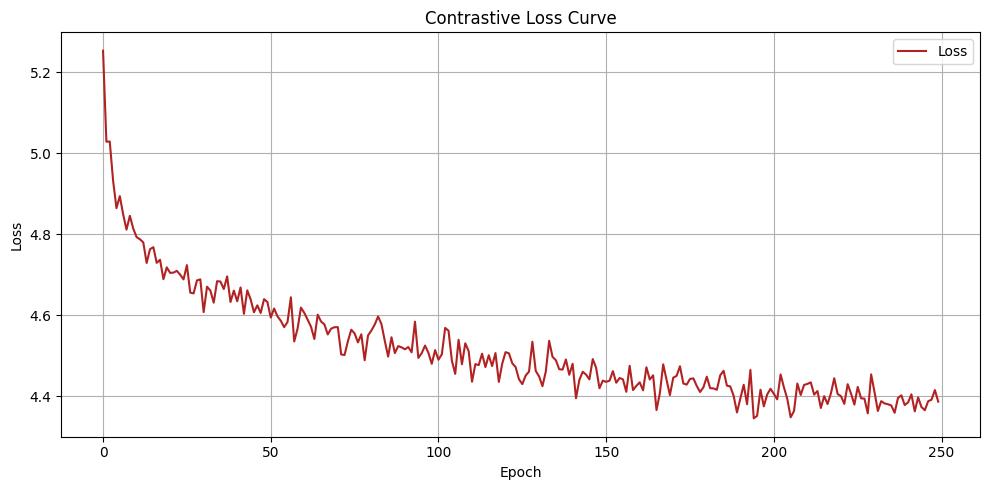

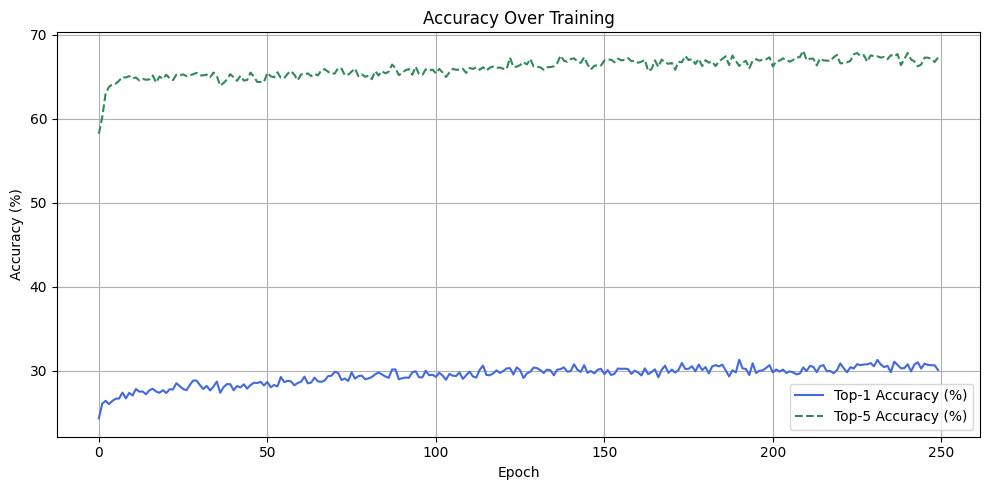

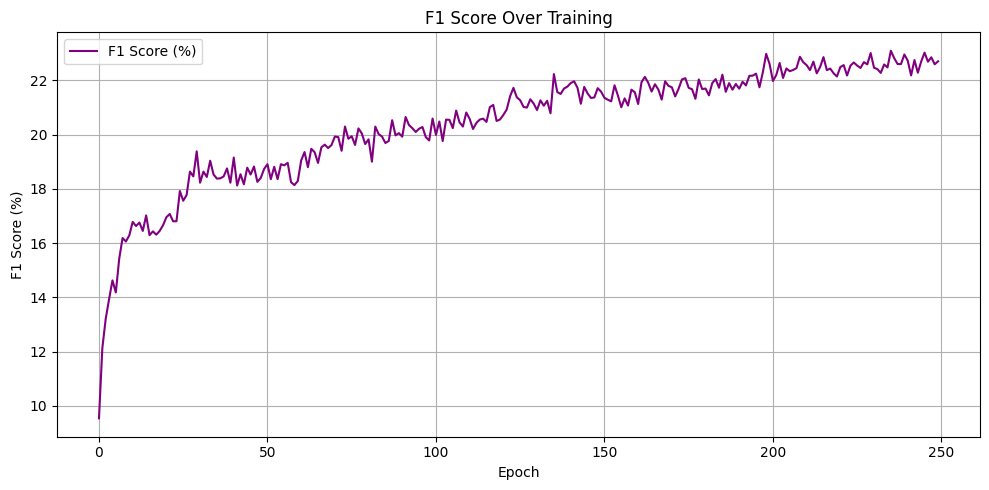

In [ ]:
# ✅ Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Loss", color='firebrick')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(top1_history, label="Top-1 Accuracy (%)", color='royalblue')
plt.plot(top5_history, label="Top-5 Accuracy (%)", linestyle="--", color='seagreen')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot F1 score curve
plt.figure(figsize=(10, 5))
plt.plot(f1_history, label="F1 Score (%)", color='purple')
plt.xlabel("Epoch")
plt.ylabel("F1 Score (%)")
plt.title("F1 Score Over Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "siamese_gnn.pth")
# To load: model.load_state_dict(torch.load("siamese_gnn.pth"))